# Sleep Data Analysis
Justin Yi  
4/22/25  
CPSC 222
Spring 2025
Description:  
This Jupyter Notebook explores, interprets, and learns my sleep data.

In [69]:
import utils
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import importlib 

importlib.reload(utils)

<module 'utils' from 'd:\\School\\Spring 2025\\Intro to Data Science\\Data Assignments\\Project\\utils.py'>

## Overview
The two datasets we'll be combining and analyzing are my personal sleep data from my time here at GU, collected by Fitbit, and weather data of Spokane courtesty of MeteoStat API. This Notebook will walk you through my cleaning, EDA, and statistical analysis. Let's take a look at what we have:

In [58]:
sleep_df = pd.read_csv("sleep_score.csv")
weather_df = utils.get_spokane_weather_df()
weather_df.to_csv("initial_spokane_weather.csv")
print(sleep_df.head())
print(weather_df.head())

   sleep_log_entry_id             timestamp  overall_score  composition_score  \
0         48988871406  2025-04-16T06:58:30Z             76                NaN   
1         48977379538  2025-04-15T08:18:30Z             71                NaN   
2         48967692815  2025-04-14T09:27:30Z             84                NaN   
3         48959170544  2025-04-13T07:16:00Z             73                NaN   
4         48948016693  2025-04-12T05:12:30Z             70                NaN   

   revitalization_score  duration_score  deep_sleep_in_minutes  \
0                    76             NaN                   55.0   
1                    71             NaN                   59.0   
2                    84             NaN                  122.0   
3                    73             NaN                   79.0   
4                    70             NaN                   14.0   

   resting_heart_rate  restlessness  
0                  64      0.083240  
1                  65      0.093929  
2 

## Cleaning and Preparation
I'd like to join both DataFrames on their date columns to get a bigger, combined dataset, but there's some cleaning we need to do:
1. For sleep_df:
    * We can drop the sleep_log_entry_id column because they serve no predictive purpose and the dates already serve as unique keys
    * We should drop instances that occur before 2023-08-26 (my first move-in day)
    * We should remove the timestamps, keep the dates, and rename the "timestamp" column to "date"
    * For classification purposes, let's decode my overall sleep scores based on [Fitbit's calculation method](https://support.google.com/fitbit/answer/14236513?hl=en#zippy=%2Cwhats-my-fitbit-sleep-score%2Chow-is-my-sleep-score-calculated-in-the-fitbit-app)
        * 90-100: Excellent
        * 80-89: Good
        * 60-79: Fair
        * <60: Poor
1. For weather_df:
    * We can drop the "00:00:00" from every date because it's constant and we want consistency with sleep_df's date column
1. We should also drop completely empty columns in both DataFrames because interpolation is literally impossible with them and they serve no purpose
1. We should also interpolate missing values for both DataFrames if possible

In [39]:
# Cleaning sleep_df
#1 Dropping ID column
sleep_df = utils.drop_column(sleep_df, "sleep_log_entry_id")
#2 Drop undesired rows
sleep_df = utils.drop_rows_by_starting_index(sleep_df, 518, 743)
#3 Clean timestamps
sleep_df = utils.remove_string_ends(sleep_df, "timestamp", 10)
sleep_df.rename(columns={"timestamp": "date"}, inplace=True)
#4 Remove the empty columns
sleep_df = utils.drop_empty_columns(sleep_df)
#5 Address missing value on 2025-03-08; we'll interpolate
sleep_df = utils.fill_missing_values(sleep_df)
#6 Decode overall sleep score
sleep_df = utils.decode_sleep_scores(sleep_df)

sleep_df.to_csv("cleaned_sleep_score.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


In [40]:
# Cleaning weather 
#1 Clean the date column
weather_df = utils.remove_string_ends(weather_df, "date", 10)
#2 Remove the empty columns
weather_df = utils.drop_empty_columns(weather_df)
#3 Fill empty data
weather_df = utils.fill_missing_values(weather_df)

weather_df.to_csv("cleaned_spokane_weather.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


In [41]:
# Joining both datasets
merged_df = sleep_df.merge(weather_df, on=["date"], how="inner")
merged_df.set_index("date", inplace=True)

There is one other thing I want to do before EDA, and that's splitting up the "date" column into day, month, and year columns.

In [42]:
# Pandas datetime object
merged_df = utils.create_datetime_columns(merged_df)
merged_df.to_csv("merged_df.csv")

## Exploratory Data Analysis
Now that our dataset is ready, we can begin exploring and understanding it. Let's get a general view of it by making a line graph:

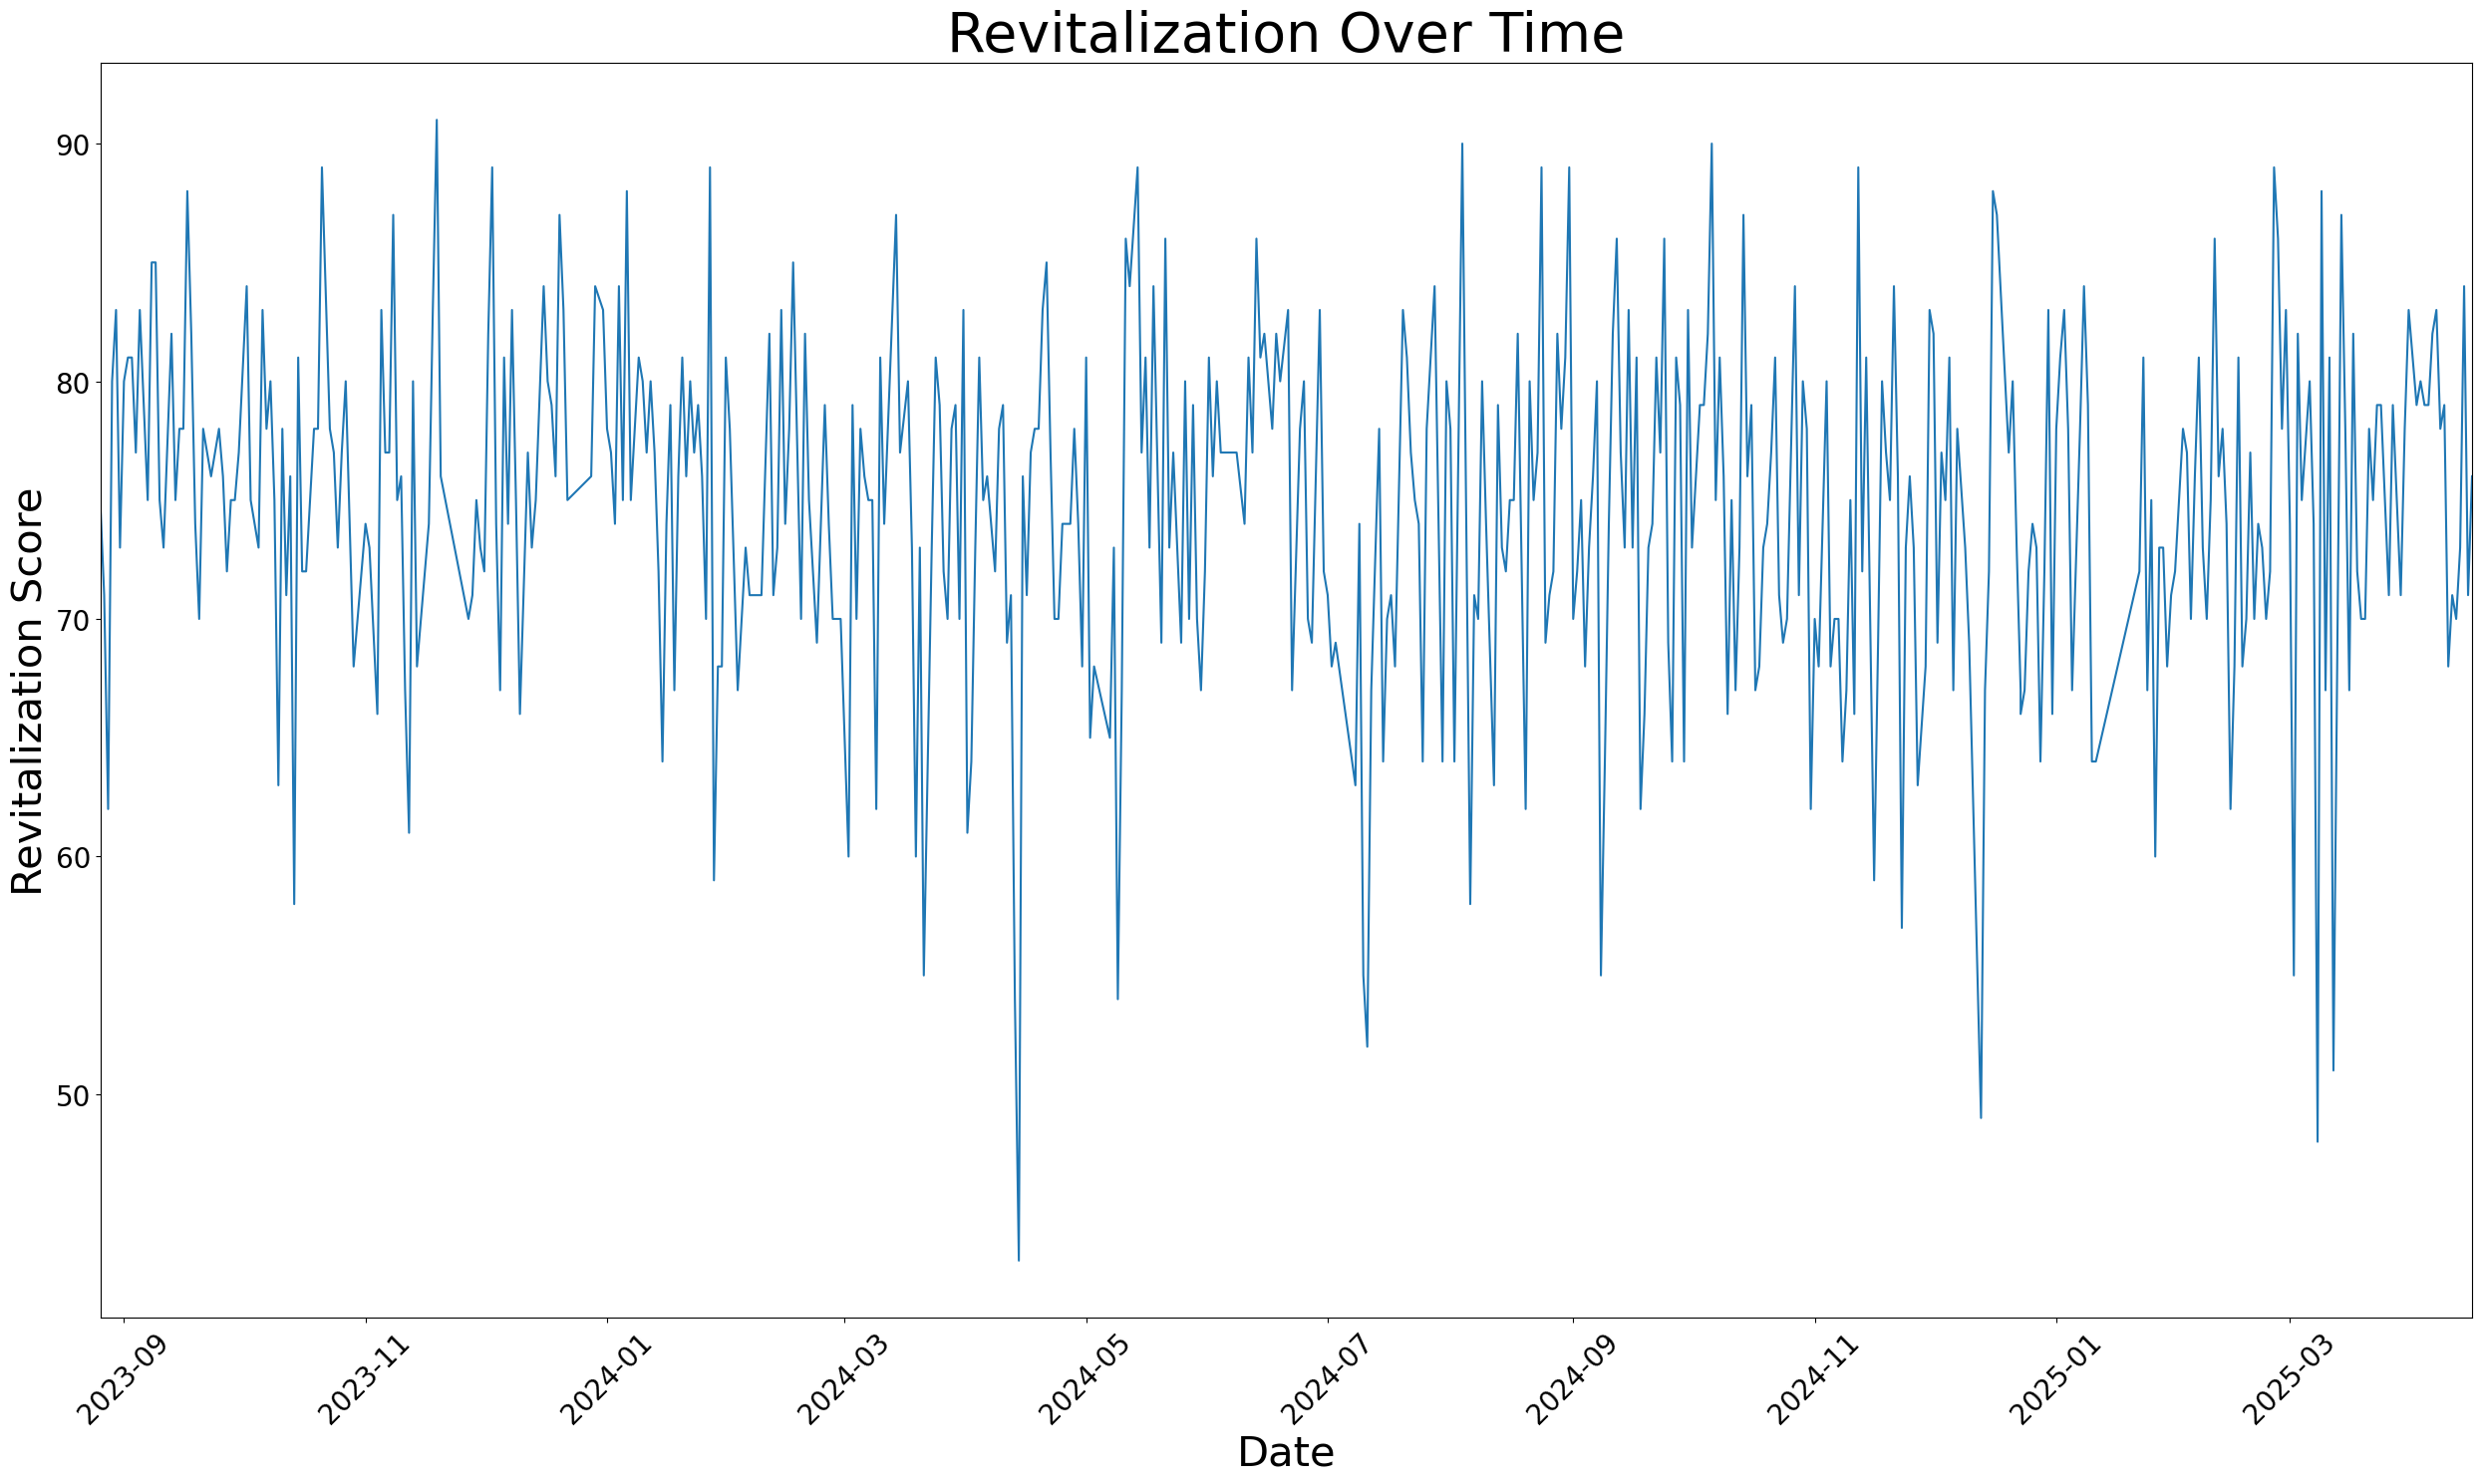

In [70]:
# Line graph
utils.create_line_graph(merged_df.index, merged_df["revitalization_score"], "Revitalization Over Time", "Date", "Revitalization Score")